# 0. Install Dependencies and Bring in Data

In [1]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "C:\ProgramData\anaconda3\lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "C:\ProgramData\anaconda3\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "C:\ProgramData\anaconda3\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "C:\ProgramData\anaconda3\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 126, in _parse_requirement_details
          marker = _parse_requirement_marker(
        File "C:\ProgramData\anaconda3\lib\

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [5]:
!pip list

Package                           Version
--------------------------------- ---------
absl-py                           2.1.0
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.5.1
anaconda-navigator                2.6.0
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           5.3.4
asttokens                   

In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000 # number of words in the vocab

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [10]:
vectorizer.adapt(X.values)

In [11]:
vectorized_text = vectorizer(X.values)

In [12]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [13]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [18]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 1161s 165ms/step - loss: 0.0617 - val_loss: 0.0482


In [19]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

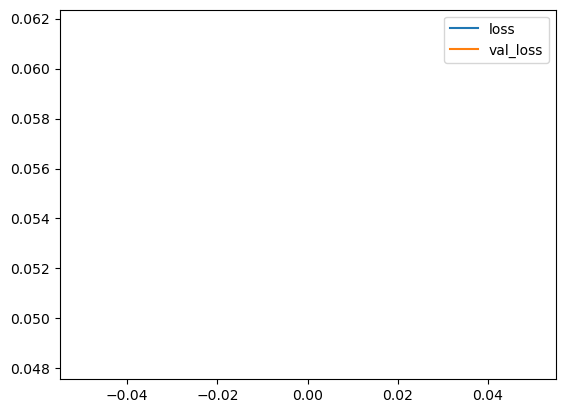

In [20]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [21]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [22]:
res = model.predict(np.array([input_text]))

1/1 [==============================] - 1s 583ms/step


In [23]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [24]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [25]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 84ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [26]:
res.shape

(1, 6)

# 4. Evaluate Model

In [27]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [28]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [29]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 83ms/step


In [30]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8265342116355896, Recall:0.6535764336585999, Accuracy:0.47241726517677307


# 5. Test and Gradio

In [58]:
!pip install gradio==3.43.1 jinja2

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/20.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/20.1 MB 9.6 MB/s eta 0:00:03
   - -------------------------------------- 0.6/20.1 MB 9.7 MB/s eta 0:00:03
   -- ------------------------------------- 1.0/20.1 MB 9.5 MB/s eta 0:00:03
   -- ------------------------------------- 1.0/20.1 MB 9.5 MB/s eta 0:00:03
   -- ------------------------------------- 1.0/20.1 MB 9.5 MB/s eta 0:00:03
   -- ------------------------------------- 1.0/20.1 MB 9.5 MB/s eta 0:00:03
   -- ------------------------------------- 1.0/20.1 MB 9.5 MB/s eta 0:00:03
   -- ------------------------------------- 1.3/20.1 MB 4.1 MB/s eta 0:00:05
   --- ------------------------------------ 1.8/20.1 MB 4.8 MB/s eta 0:00:04
   ---- ----------------------------------- 2.1/20.1 MB 5.1 MB/s eta 0:00:04
   ---- ----------------------------------- 2.1/20.1 MB 5.1 MB/s eta 0:00:04
   --

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [49]:
import tensorflow as tf
import gradio as gr

In [50]:
model.save('toxicity.h5')

In [51]:
model = tf.keras.models.load_model('toxicity.h5')

In [52]:
input_str = vectorizer('hey i freaken hate you!')

In [53]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 551ms/step


In [54]:
res

array([[0.7630907 , 0.0130124 , 0.3109844 , 0.02166972, 0.3388552 ,
        0.05707455]], dtype=float32)

In [55]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [57]:
interface = gr.Interface(fn=score_comment, inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),outputs='text')

AttributeError: module 'gradio' has no attribute 'inputs'

In [ ]:
interface.launch(share=True)